<a id="4"></a> <br>
### DATAI PyTorch tutorials - https://www.kaggle.com/kanncaa1/pytorch-tutorial-for-deep-learning-lovers
### Recurrent Neural Network (RNN)
- RNN is essentially repeating ANN but information get pass through from previous non-linear activation function output.
- **Steps of RNN:**
    1. Import Libraries
    1. Prepare Dataset
    1. Create RNN Model
        - hidden layer dimension is 100
        - number of hidden layer is 1 
    1. Instantiate Model
    1. Instantiate Loss
        - Cross entropy loss
        - It also has softmax(logistic function) in it.
    1. Instantiate Optimizer
        - SGD Optimizer
    1. Traning the Model
    1. Prediction

# 1. Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [2]:
sorted([f for f in os.listdir('data') if not f.startswith('.')], key=lambda f: f.lower())

['sample_submission.csv', 'test.csv', 'train.csv']

# 2. Prepare Dataset

In [3]:
# Prepare Dataset
# load data
train = pd.read_csv(r"data/train.csv", dtype=np.float32)

In [4]:
# split data into features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255 # normalization

In [5]:
# train test split. Size of train data is 80% and size of test data is 20%. 
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42)

In [6]:
# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. 
# Therefore first we create tensor, then we will create variable
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

In [7]:
# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

In [8]:
# batch_size, epoch and iteration
batch_size = 100
n_iters = 8000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

In [9]:
# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

In [10]:
# data loader
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

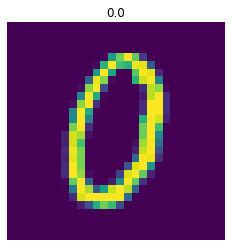

In [11]:
# visualize one of the images in data set
plt.imshow(features_numpy[5].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[5]))
plt.savefig('graph.png')
plt.show()

# 3. Create RNN Model

In [12]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        
        # Initialize hidden state with zeros
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
            
        # One time step
        out, hn = self.rnn(x, h0)
        out = self.fc(out[:, -1, :]) 
        return out

# 4. Instantiate Model Class

In [13]:
input_dim = 28    # input dimension
hidden_dim = 100  # hidden layer dimension
layer_dim = 1     # number of hidden layers
output_dim = 10   # output dimension

In [14]:
model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

# 5. Instantiate Loss (Cross Entropy Loss)  

In [15]:
error = nn.CrossEntropyLoss()

# 6. Instantiate Optimizer (SGD Optimizer) 

In [16]:
learning_rate = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# 7. Training the Model

In [18]:
seq_dim = 28  
loss_list = []
iteration_list = []
accuracy_list = []
count = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        train  = Variable(images.view(-1, seq_dim, input_dim))
        labels = Variable(labels )
            
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        if count % 250 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images = Variable(images.view(-1, seq_dim, input_dim))
                
                # Forward propagation
                outputs = model(images)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += labels.size(0)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            if count % 500 == 0:
                # Print Loss
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

Iteration: 500  Loss: 1.272521734237671  Accuracy: 53.30952453613281 %
Iteration: 1000  Loss: 0.765259325504303  Accuracy: 68.08333587646484 %
Iteration: 1500  Loss: 0.6350246071815491  Accuracy: 79.02381134033203 %
Iteration: 2000  Loss: 0.3951175808906555  Accuracy: 80.05952453613281 %
Iteration: 2500  Loss: 0.6603347063064575  Accuracy: 78.88095092773438 %
Iteration: 3000  Loss: 0.1592596024274826  Accuracy: 92.57142639160156 %
Iteration: 3500  Loss: 0.3104259967803955  Accuracy: 92.19047546386719 %
Iteration: 4000  Loss: 0.13631001114845276  Accuracy: 92.98809814453125 %
Iteration: 4500  Loss: 0.35945725440979004  Accuracy: 94.45237731933594 %
Iteration: 5000  Loss: 0.12890350818634033  Accuracy: 95.3452377319336 %
Iteration: 5500  Loss: 0.18723684549331665  Accuracy: 95.11904907226562 %
Iteration: 6000  Loss: 0.3213830292224884  Accuracy: 95.11904907226562 %
Iteration: 6500  Loss: 0.07994449883699417  Accuracy: 95.63095092773438 %
Iteration: 7000  Loss: 0.179743692278862  Accuracy

# 8. Visualization

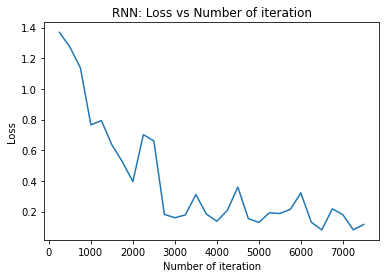

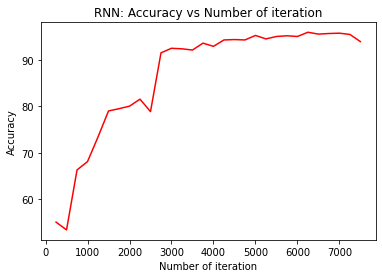

In [19]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("RNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("RNN: Accuracy vs Number of iteration")
plt.savefig('graph.png')
plt.show()

## While loss decreasing, accuracy is increasing. That refers to model is learning!